[0.         0.04979924 0.09959849 0.14939773 0.19919698 0.24899622
 0.29879546 0.34859471 0.39839395 0.4481932  0.49799244 0.54779169
 0.59759093 0.64739017 0.69718942 0.74698866 0.79678791 0.84658715
 0.89638639 0.94618564 0.99598488]


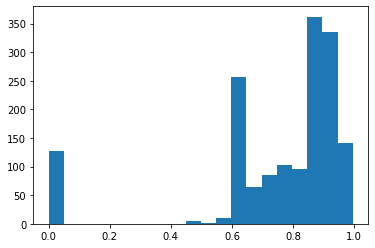

In [10]:
import snap
import numpy as np
import matplotlib.pyplot as plt

def GetEgonetIntraEdges(Node, Graph):
    k = Node.GetDeg()
    nIntraEdges = k
    for i in range(k-1):
        for j in range(i+1, k):
            nbr1 = Node.GetNbrNId(i)
            nbr2 = Node.GetNbrNId(j)
            if Graph.IsEdge(nbr1, nbr2):
                nIntraEdges += 1
    return nIntraEdges

def GetEgonetOuterEdges(Node, Graph):
    k = Node.GetDeg()
    nbrs = [Node.GetNbrNId(i) for i in range(k)]
    nOuterEdges = 0
    for i in range(k):
        NI = Graph.GetNI(Node.GetNbrNId(i))
        kN = NI.GetDeg()
        c = kN - 1
        for j in range(kN):
            if NI.GetNbrNId(j) in nbrs:
                c -= 1
        nOuterEdges += c
    return nOuterEdges

def BasicFeature(Node, Graph):
    deg = Node.GetDeg()
    nIntraEdges = GetEgonetIntraEdges(Node, Graph)
    nOuterEdges = GetEgonetOuterEdges(Node, Graph)
    return np.array([deg, nIntraEdges, nOuterEdges])

def RecursiveFeature(Graph, K=2):
    Vs = {NI.GetId(): BasicFeature(NI, Graph) 
          for NI in Graph.Nodes()}
    for it in range(K):
        Vs_cur = {k: v for k, v in Vs.items()}
        for NId, _ in Vs.items():
            NI = Graph.GetNI(NId)
            Vu = Vs_cur[NId]
            if NI.GetDeg() == 0:
                Vsum = np.zeros_like(Vu)
                Vmean = np.zeros_like(Vu)
            else:
                Vsum = np.zeros_like(Vu)
                for i in range(NI.GetDeg()):
                    Vsum += Vs_cur[NI.GetNbrNId(i)]
                Vmean = Vsum / NI.GetDeg()
            Vs[NI.GetId()] = np.hstack([Vu, Vmean, Vsum])
    return Vs

def CosineSimilarity(x, y):
    xx = np.dot(x, x)
    yy = np.dot(y, y)
    if xx == 0 or yy == 0:
        return 0.0
    else:
        xy = np.dot(x, y)
        return float(xy) / np.sqrt(xx * yy)

def FindNearestKBasic(NId, Graph, k):
    Vs = {}
    for NI in Graph.Nodes():
        Vs[NI.GetId()] = BasicFeature(NI, Graph)

    dsts = []
    for NI in Graph.Nodes():
        if NI.GetId() == NId:
            continue
        d = CosineSimilarity(Vs[NId], Vs[NI.GetId()])
        dsts.append((d, NI.GetId(), Vs[NI.GetId()]))
    dsts = sorted(dsts, reverse=True)
    return dsts[:k]

def FindNearestKRecursive(NId, Graph, k, K):
    Vs = RecursiveFeature(G, K)
    dsts = []
    for NI in Graph.Nodes():
        if NI.GetId() == NId:
            continue
        d = CosineSimilarity(Vs[NId], Vs[NI.GetId()])
        dsts.append((d, NI.GetId(), Vs[NI.GetId()]))
    dsts = sorted(dsts, reverse=True)
    return dsts[:k]

def Draw(a, name, NId):
    NIdColorH = snap.TIntStrH()
    NIdColorH[NId] = 'green'
    for d, Id, _ in a:
        NIdColorH[Id] = "red"
    snap.DrawGViz(G, snap.gvlNeato, name+'.png', name, True, NIdColorH)

# G = snap.GenRndGnm(snap.PUNGraph, 500, 1000)
# snap.DrawGViz(G, snap.gvlNeato, "test.png", "Test", True)

NId = 9
path = 'data/hw1-q2.graph'
G = snap.TUNGraph.Load(snap.TFIn(path))

# a_basic = FindNearestKBasic(NId, G, 5)
# print(a_basic)
# Draw(a_basic, 'basic', NId)
# a_recursive = FindNearestKRecursive(NId, G, 5, 2)
# print(a_recursive)
# Draw(a_recursive, 'rec', NId)

Vs = RecursiveFeature(G, 2)
dsts = [
    CosineSimilarity(Vs[NId], Vs[NI.GetId()])
    for NI in G.Nodes()
    if NI.GetId() != NId
]
a, b, c = plt.hist(dsts, bins=20)
print(b)